# ロックイン検出とヘテロダイン解析

高周波の搬送波（キャリア）に情報が載っているような信号から、振幅や位相のゆっくりとした変化を抽出する手法を **ロックイン検出（Lock-in detection）** または **ヘテロダイン検波（Heterodyne detection）** と呼びます。

このチュートリアルでは、以下の流れで解析を実演します。

1.  **変調信号の生成**: 100Hzのキャリア信号に対し、ゆっくりとした振幅変調と位相ドリフトを加え、強めのノイズを混合します。
2.  **ロックイン検出 (`lock_in`)**: `gwexpy` の `lock_in` メソッドを使用して、参照周波数に基づいた振幅と位相の自動抽出を行います。
3.  **マニュアル復調 (`mix_down`)**: 信号に参照波（正弦波と余弦波）を掛け合わせて低域フィルタを通す、より原理的なプロセスを体験します。
4.  **結果の比較**: 抽出された振幅・位相と、最初にシミュレーションした変調信号を比較し、その精度を確認します。


In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from gwexpy import TimeSeries, TimeSeriesDict

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["axes.unicode_minus"] = False


## 1. 変調信号のシミュレーション (Simulated Signal)

以下の成分を持つ信号を作成します：
*   **キャリア**: 100 Hz
*   **振幅変調 (AM)**: 0.2 Hz の正弦波的な変動
*   **位相変調 (PM)**: 0.05 Hz のゆっくりとしたドリフト
*   **ノイズ**: 白色雑音


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


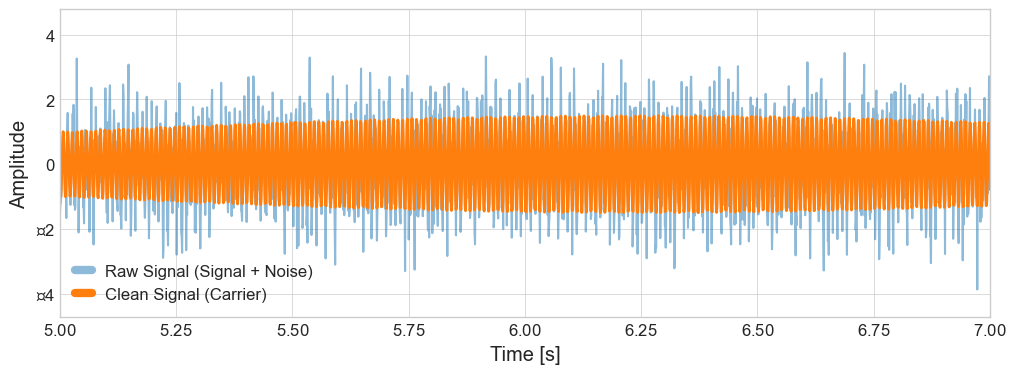

In [2]:
fs = 1024.0      # サンプリング周波数 [Hz]
duration = 40.0  # データ長 [s]
t = np.arange(0, duration, 1/fs)

np.random.seed(42)

# 1. 搬送波 (Carrier)
f_carrier = 100.0

# 2. 振幅変調 (Amplitude Modulation)
# 1.0 を中心に +/- 0.5 変動
amp_mod = 1.0 + 0.5 * np.sin(2 * np.pi * 0.2 * t)

# 3. 位相変調 (Phase Modulation / Drift)
# ラジアン単位での位相のズレ
phase_mod = 2.0 * np.sin(2 * np.pi * 0.05 * t)

# --- 信号の合成 ---
# x(t) = A(t) * sin(2*pi*f_c*t + phi(t))
clean_signal = amp_mod * np.cos(2 * np.pi * f_carrier * t + phase_mod)

# ノイズを付加
noise = np.random.normal(0, 0.8, len(t))
ts = TimeSeries(clean_signal + noise, sample_rate=fs, name="Modulated Signal", unit="V")

# 可視化
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(ts.times, ts.value, alpha=0.5, label="Raw Signal (Signal + Noise)")
ax.plot(ts.times, clean_signal, label="Clean Signal (Carrier)", linewidth=2)
ax.set_xlim(5, 7) # 一部を拡大
ax.set_xlabel("Time [s]")
ax.set_ylabel("Amplitude")
ax.legend()
plt.show()

# ノイズが大きく、このままでは振幅や位相の変動を目視で捉えるのは困難です。


## 2. ロックイン検出 (Extracting Amplitude and Phase)

`gwexpy` の `lock_in()` メソッドを使用すると、指定した周波数 `f0` における振幅と位相のトレンドを簡単に抽出できます。
内部的には、信号を復調（複素ヘテロダイン）し、`stride` 秒ごとの平均値を計算します。


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


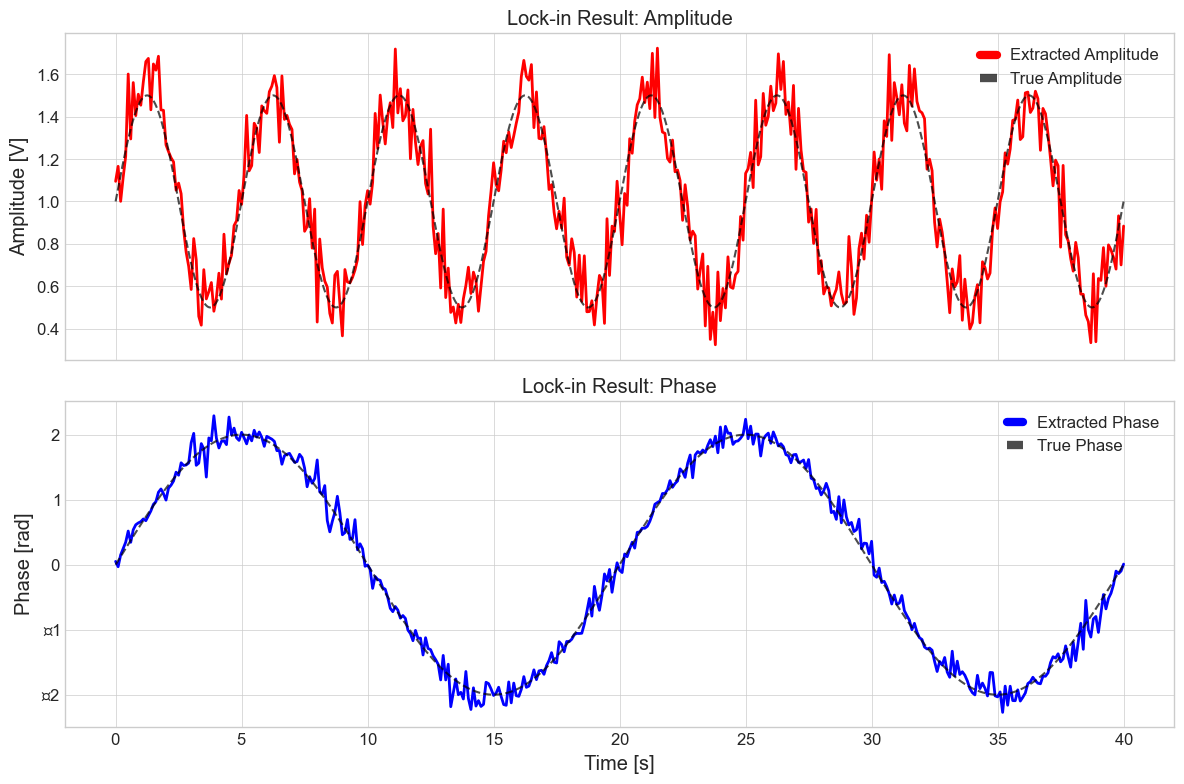

In [3]:
# stride=0.1s (10Hz相当) で振幅と位相を抽出
#出力形式は 'amp_phase' (デフォルト)
amp, phase = ts.lock_in(f0=f_carrier, stride=0.1, output='amp_phase', deg=False)

# プロット
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(amp.times, amp.value, label="Extracted Amplitude", color="red", linewidth=2)
ax1.plot(t, amp_mod, label="True Amplitude", color="black", ls="--", alpha=0.7)
ax1.set_ylabel("Amplitude [V]")
ax1.legend()
ax1.set_title("Lock-in Result: Amplitude")

ax2.plot(phase.times, phase.value, label="Extracted Phase", color="blue", linewidth=2)
ax2.plot(t, phase_mod, label="True Phase", color="black", ls="--", alpha=0.7)
ax2.set_ylabel("Phase [rad]")
ax2.legend()
ax2.set_title("Lock-in Result: Phase")

plt.xlabel("Time [s]")
plt.tight_layout()
plt.show()

# ノイズに埋もれていた信号から、元の変調が見事に復元されていることが分かります。


## 3. マニュアル復調 (Manual Demodulation / Mixing)

ロックインの内部動作を知るために、手動でも復調を行ってみましょう。
1.  参照波（$\cos(2 \pi f_c t)$ と $\sin(2 \pi f_c t)$）を掛け合わせます。
2.  低域フィルタ（Low-pass filter）で高周波成分（$2 f_c$ 成分）とノイズを除去します。
3.  I（実部）と Q（虚部）から振幅と位相を計算します。


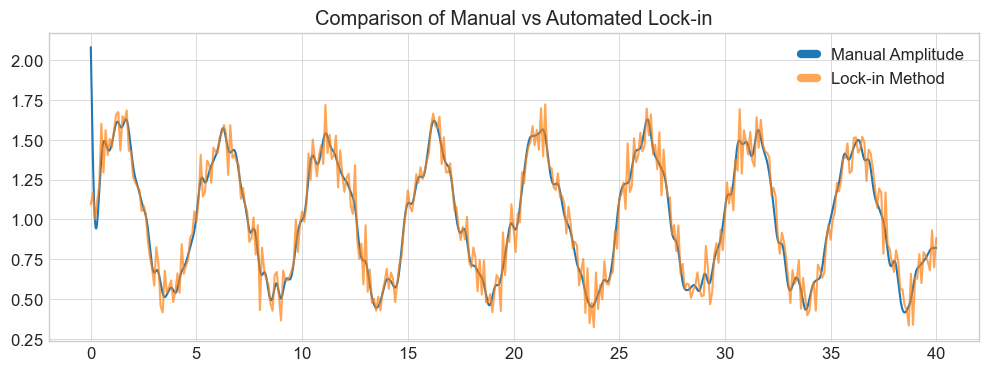

In [4]:
# 1. ミキシング (Mixing)
# gwexpy の mix() は、与えられた波形との積を計算します。
ref_cos = np.cos(2 * np.pi * f_carrier * t)
ref_sin = np.sin(2 * np.pi * f_carrier * t)

# 2*np.cos * ref_cos => 1.0 + cos(2*2*pi*f_c*t)
mixed_i = (ts * ref_cos) * 2.0
mixed_q = (ts * (-ref_sin)) * 2.0 # 位相の定義により符号反転

# 2. 低域フィルタ (Low-pass Filter)
# キャリア周波量(100Hz)より十分低い 2Hz などの LPF を通す
b, a = signal.butter(4, 2.0, fs=fs, btype='low')
i_filtered = TimeSeries(signal.filtfilt(b, a, mixed_i.value), sample_rate=fs)
q_filtered = TimeSeries(signal.filtfilt(b, a, mixed_q.value), sample_rate=fs)

# 3. 振幅と位相の算出
amp_manual = np.sqrt(i_filtered**2 + q_filtered**2)
phase_manual = np.arctan2(q_filtered.value, i_filtered.value)

# 可視化 (Step 2 と同様の結果が得られるはずです)
plt.figure(figsize=(12, 4))
plt.plot(amp_manual.times, amp_manual.value, label="Manual Amplitude")
plt.plot(amp.times, amp.value, label="Lock-in Method", alpha=0.7)
plt.title("Comparison of Manual vs Automated Lock-in")
plt.legend()
plt.show()


## 4. スペクトル領域での理解

復調した信号のスペクトルを見ると、本来 100Hz 付近にあった微細な構造が、0Hz（DC）付近に移動していることが分かります。


Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.


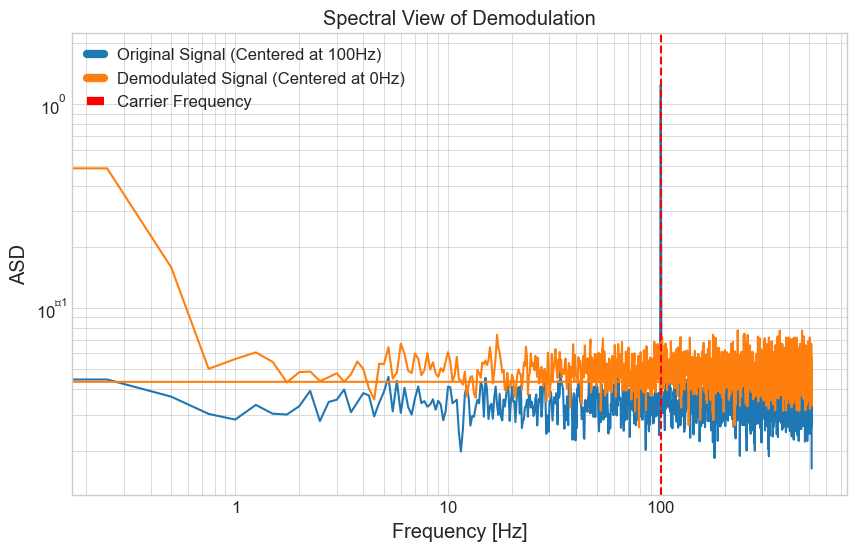

In [5]:
# 元の信号の ASD
asd_raw = ts.asd(fftlength=4)
# 復調後の複素信号 (出力 'complex' を使用)
complex_signal = ts.lock_in(f0=f_carrier, stride=1/fs, output='complex')
asd_demod = complex_signal.asd(fftlength=4)

plt.figure(figsize=(10, 6))
plt.loglog(asd_raw.frequencies, asd_raw.value, label="Original Signal (Centered at 100Hz)")
plt.loglog(asd_demod.frequencies, asd_demod.value, label="Demodulated Signal (Centered at 0Hz)")
plt.axvline(f_carrier, color="red", ls="--", label="Carrier Frequency")

plt.title("Spectral View of Demodulation")
plt.xlabel("Frequency [Hz]")
plt.ylabel("ASD")
plt.legend()
plt.grid(True, which="both")
plt.show()

# ロックイン解析によって、高周波に存在する目的の情報を、
# 低周波のトレンド解析の手法で扱えるようになったことが分かります。
